This notebook provides an example code for using the IGA2D class

In [1]:
import IGA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_case_1(num_knots, order, delta, norm, quad_degree=10):

    h = 1.0 / num_knots

    if delta > h:
        num_boundary_elements = np.ceil(delta / h)
    else:
        num_boundary_elements = 1

    omega_p1 = np.linspace(-delta, 0, num=(num_boundary_elements + 1))
    omega = np.linspace(0, 1, num=(num_knots+1))
    omega_p2 = np.linspace(1, 1 + delta, num=(num_boundary_elements + 1))

    knot_vector = np.r_[-delta * np.ones(order), omega_p1[:-1], omega[:-1], omega_p2, np.ones(order) * (1 + delta)]

    iga = IGA.PD1D(knot_vector, order, delta)
    iga.degree = quad_degree
    
    u = lambda x: x * (1 - x)
    b = lambda x: np.ones(x.shape[0])

    iga.compute_solutions(u, b, num_boundary_elements)
    
    return iga.compute_error(norm=norm)

In [3]:
dofs = np.array([10,60,100,200])
errs = [ run_case_1(num_knots, order=1, delta=0.25, norm=2, quad_degree=4) for num_knots in dofs ]

[[[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.95051129  0.04948871  0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.91062503 ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]]

 [[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.68993365  0.31006635  0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.65004739 ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]]

 [[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.34995261  0.65004739  0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.31006635 ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]]

 ..., 
 [[ 0.         

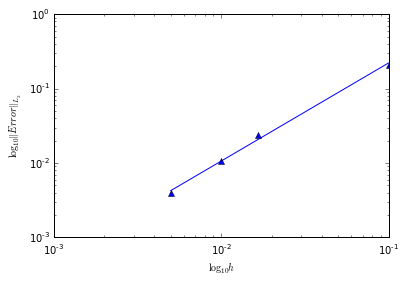

In [4]:
#Fit a straight line
coefs = np.polyfit(np.log10(1.0 / dofs), np.log10(errs), 1)
y = 10 ** (coefs[0] * np.log10(1.0 / dofs) + coefs[1])
#Plot
plt.loglog(1.0 / dofs, y, 'b-')
plt.loglog(1.0 / dofs, errs, 'b^')
plt.xlabel("$\log_{10} h$")
plt.ylabel("$\log_{10} \Vert Error \Vert_{L_2}$");

In [5]:
def run_case_2(num_knots, order, delta, norm, quad_degree=10):

    h = 1.0 / num_knots

    if delta > h:
        num_boundary_elements = np.ceil(delta / h)
    else:
        num_boundary_elements = 1

    omega_p1 = np.linspace(-delta, 0, num=(num_boundary_elements + 1))
    omega = np.linspace(0, 1, num=(num_knots+1))
    omega_p2 = np.linspace(1, 1 + delta, num=(num_boundary_elements + 1))

    knot_vector = np.r_[-delta * np.ones(order), omega_p1[:-1], omega[:-1], omega_p2, np.ones(order) * (1 + delta)]

    iga = IGA.PD1D(knot_vector, order, delta)
    iga.degree = quad_degree
    
    u = lambda x: x * (1 - x)
    b = lambda x: np.ones(x.shape[0])

    iga.compute_solutions(u, b, num_boundary_elements)
    
    return iga

In [6]:
iga2 = run_case_2(5, order=1, delta=0.25, norm=2, quad_degree=4)

[[[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.61053024  0.38946976  0.         ...,  0.          0.          0.        ]
  [ 0.          0.25060607  0.74939393 ...,  0.          0.          0.        ]
  [ 0.          0.          0.50518471 ...,  0.          0.          0.        ]]

 [[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.34995261  0.65004739  0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.99376777 ...,  0.          0.          0.        ]
  [ 0.          0.          0.34232369 ...,  0.          0.          0.        ]]

 [[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.00997157  0.99002843  0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.78127962 ...,  0.          0.          0.        ]
  [ 0.          0.          0.12983553 ...,  0.          0.          0.        ]]

 ..., 
 [[ 0.         

In [7]:
iga2.N(np.array([0.05]))

array([[ 0.  ,  0.  ,  0.75,  0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

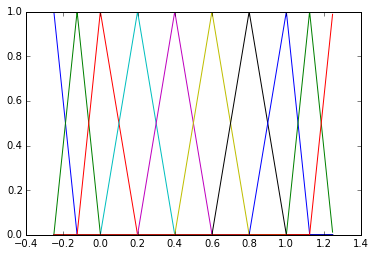

In [8]:
iga2.N.plot()

In [9]:
iga2.build_connectivity_array()

array([], shape=(9, 0), dtype=int64)

In [10]:
global_index_arr = np.


SyntaxError: invalid syntax (<ipython-input-10-0a151e98db29>, line 1)